In [17]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [18]:
sc = SparkContext()

In [19]:
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [20]:
socket_stream = ssc.socketTextStream('127.0.0.1',9999)

In [21]:
lines = socket_stream.window(20)

In [22]:
from collections import namedtuple
fields = ('tag', 'count')
Tweet = namedtuple('Tweet', fields)

In [23]:
( lines.flatMap( lambda text: text.split( " " ) ) 

  .filter( lambda word: word.lower().startswith("#") ) 

  .map( lambda word: ( word.lower(), 1 ) ) 

  .reduceByKey( lambda a, b: a + b ) 

  .map( lambda rec: Tweet( rec[0], rec[1] ) ) 

  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) 

  .limit(10).registerTempTable("tweets") ) ) 

In [24]:
ssc.start()

In [25]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

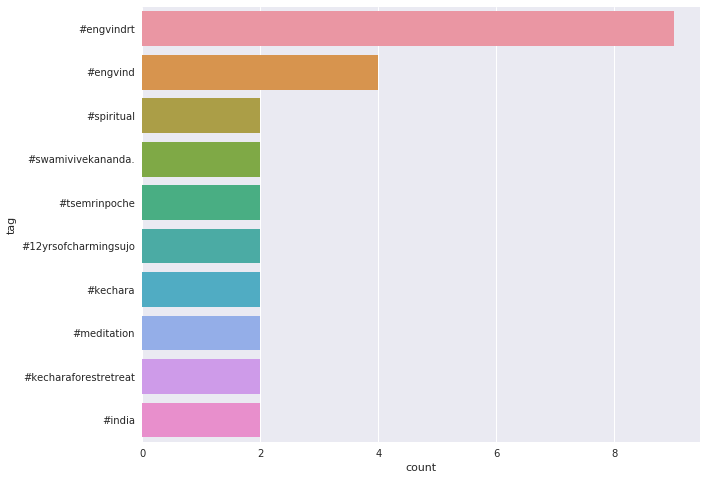

In [27]:
count = 0
while count < 10:
    time.sleep(3)
    top_10_tweets = sqlContext.sql('SELECT tag, count FROM tweets')
    top_10_dfs = top_10_tweets.toPandas()
    display.clear_output(wait = True)
    sns.set()
    plt.figure(figsize = (10,8))
    sns.barplot(x="count", y="tag", data = top_10_dfs)
    plt.show()
    count = count + 1

In [28]:
ssc.stop()